# Extract bbox

The purpose of this script is to draw a bounding box on each white-backgrounded image from simulation.

This involves the following steps:
- Extract all bboxes
- Keep image only if 1 bbox
- Save image and bbox in yolo format in separate folders

To use the data drag it to your training folder.

In [13]:
# imports

import cv2
import shutil
import os
import matplotlib.pyplot as plt

In [16]:
# create output folders

if os.path.exists('output'):
    shutil.rmtree('output')

os.makedirs('output/images', exist_ok=True)
os.makedirs('output/labels', exist_ok=True)

### Functions

In [17]:
def preprocess_image(image):
    """
    Preprocess the image (grayscale conversion and thresholding).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # Threshold to create a binary image
    return thresh

def find_contours(thresh_image):
    """
    Find contours in the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def extract_yolo_bbox(contour, img_width, img_height):
    """
    Extract a single YOLO bounding box (for exactly one contour).
    """
    x, y, w, h = cv2.boundingRect(contour)

    # YOLO format values
    x_center = (x + w / 2) / img_width   # Normalized x center
    y_center = (y + h / 2) / img_height  # Normalized y center
    width = w / img_width                # Normalized width
    height = h / img_height              # Normalized height

    return (x, y, w, h, x_center, y_center, width, height)

def draw_bbox_on_image(image, bbox):
    """
    Draw bounding box on the image.
    """
    x, y, w, h = bbox[:4]
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # draw rectangle
    return image

def display_image(image):
    """
    Display the image using matplotlib.
    """
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
    plt.axis('off')  
    plt.show()

def process_images_in_folder(folder_path):
    """
    Process all images in the folder and only process images with exactly one contour.
    """
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(".jpg") or img.endswith(".png")]

    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read image: {image_path}")
            continue
        
        # pipeline
        img_height, img_width = image.shape[:2]
        thresh_image = preprocess_image(image)
        contours = find_contours(thresh_image)
        if len(contours) == 0:
            print(f"No contours found in image: {os.path.basename(image_path)}")
            continue
        largest_contour = max(contours, key=cv2.contourArea)
        bbox = extract_yolo_bbox(largest_contour, img_width, img_height)

        # display
        print(f"Image: {os.path.basename(image_path)}")
        image_with_bbox = draw_bbox_on_image(image, bbox)
        display_image(image_with_bbox)

        # save

        image_save_path = os.path.join('output/images', os.path.basename(image_path))
        os.makedirs('output/images', exist_ok=True)
        cv2.imwrite(image_save_path, image_with_bbox)

        label_save_path = os.path.join('output/labels', os.path.splitext(os.path.basename(image_path))[0] + '.txt')
        with open(label_save_path, 'w') as f:
            class_id = 0  
            x_center, y_center, width, height = bbox[4:]
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

### Process images

Image: image_empty_39.jpg


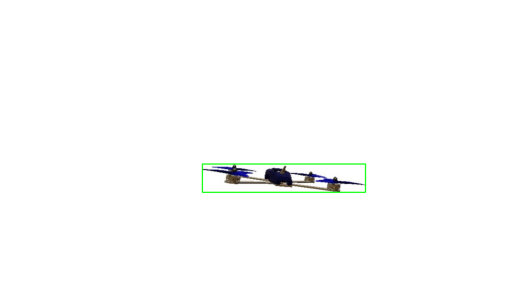

In [18]:
# process

folder_path = 'white_background_images'

process_images_in_folder(folder_path)